# Recurrent Neural Networks
---
# Predicting Stock Prices through an LSTM model

In [1]:
import tensorflow as tf
import requests

''' Linear Algebra '''
import pandas as pd
import numpy as np
pd.set_option("max_columns",None)

'''Data visualization'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

In [2]:
''' Hnadling timestamps'''
import datetime
from datetime import datetime

In [3]:
CLOSE = 'close'
WINDOW_SIZE = 18
#HORIZON = 6
SELECTED_FEATURES = ['close']

In [4]:
# url = 'https://raw.githubusercontent.com/timjab92/cryptotradingindicator/master/data/BTC4h.csv'

# data = pd.read_csv(url)
# Dataset is now stored in a Pandas Dataframe

In [5]:
def feature_engineer(data):
    """
    Adds the EMAs, StochRSI, BollingerBands and Volume Rate of Change to the dataframe
    """
    add_ema(data)
    add_stoch_rsi(data)
    add_bollinger(data,data[CLOSE])
    add_vol_roc(data)
    data['4h Return'] = data[CLOSE].pct_change() * 100 
    data['4h Gradient'] = data[CLOSE].diff()
    data['boll_width'] = data['bollinger_up'] - data['bollinger_down']
    data['high_low_avg'] =  data[['high','low']].mean(axis=1)
    data['stoch_rsi'] = (data['K'] + data['D']) / 2
    data['perc_bb'] = (data.close - data.bollinger_down) / (data.bollinger_up - data.bollinger_down)
    return data

## add other features

def add_ema(data, tspan=[12,26,21,50,34,55,99,200]):
    """
    Adds Exponential Moving Averages (EMA) to the dataframe. The default timeframes are 12,26,20,50,34 and 55.
    """
    for t in tspan:
        data[f'ema{t}'] = data[CLOSE].ewm(span=t).mean()
        data[f'dist_ema{t}'] = data[CLOSE] - data[f'ema{t}']
    return data


def computeRSI(data, window=14):
    """
    Computes the Relative Stregth Index for a given dataset and the window can be defined. Its default value is 14.
    """
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=window-1 so we get decay alpha=1/window
    up_chg_avg   = up_chg.ewm(com=window-1 , min_periods=window).mean()
    down_chg_avg = down_chg.ewm(com=window-1 , min_periods=window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi


def stoch_rsi(rsi, d_window=3, k_window=3, window=14):
    """
    Computes the stochastic RSI. Default values are d=3, k=3, window=14.
    """
    minrsi = rsi.rolling(window=window, center=False).min()
    maxrsi = rsi.rolling(window=window, center=False).max()
    stoch = ((rsi - minrsi) / (maxrsi - minrsi)) * 100
    K = stoch.rolling(window=k_window, center=False).mean()
    D = K.rolling(window=d_window, center=False).mean() 
    return K, D  


def add_stoch_rsi(data, d_window=3, k_window=3, window=14):
    data['rsi'] = computeRSI(data[CLOSE], window)
    data['K'], data['D'] = stoch_rsi(data['rsi'], d_window, k_window, window)
    return data


def get_bollinger_bands(prices, rate=20):
    sma = prices.rolling(rate).mean() # <-- Get SMA for 20 days
    std = prices.rolling(rate).std() # <-- Get rolling standard deviation for 20 days
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return sma, bollinger_up, bollinger_down


def add_bollinger(data, prices, rate=20):
    data['sma'], data['bollinger_up'], data['bollinger_down'] = get_bollinger_bands(prices)
    for i in ['bollinger_up', 'bollinger_down']:
        data[f'dist_{i}'] = data[CLOSE] - data[i]
    return data


def add_vol_roc(data):
    data['vol_roc'] = data.volume.pct_change()
    return data

def get_train_data():
    """
    Returns the raw training dataset for the price of bitcoin since 31.12.2011.
    The index is set to the date.
    """
    url = 'https://raw.githubusercontent.com/timjab92/cryptotradingindicator/master/data/BTC4h.csv'
    data = pd.read_csv(url)
    
    data['date'] = pd.to_datetime(data.date)
    data_train = data.set_index("date")
    return data_train


def get_coingecko():
    #ohlc
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/ohlc?vs_currency=usd&days=30"
    response = requests.get(url).json()
    #cleaning
    data_api = pd.DataFrame(response, columns = ['unix_time','open', 'high', 'low', 'close'])
    data_api["Date"] = pd.to_datetime(data_api["unix_time"], unit='ms')
    data_api = data_api.drop(columns='unix_time').set_index('Date')

    #volume
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=30"
    response = requests.get(url).json()

    volume = pd.DataFrame(response['total_volumes'], columns=["unix_time","volume"])
    volume['date'] = pd.to_datetime(pd.to_datetime(volume['unix_time'],unit='ms').dt.strftime("%Y/%m/%d, %H:00:00"))
    volume = volume.drop(columns='unix_time').set_index('date')

    #resample hourly into 4h
    volume = volume.resample("4H").mean()

    #concatinate
    volume = volume[-180:]
    data_api = data_api[-181:-1]
    full = pd.concat([data_api, volume], axis=1)
    full.columns=['open', 'high', 'low', 'close', 'volume']

    for x in ['open', 'high', 'low', 'close']:
        full[f'log_{x}'] = full[x].apply(lambda x: np.log(x))

    data_api = full.copy()

    return data_api


def minmaxscaling(data_train):
    """
    applies the minmaxscaler to the training set. Attention! Output needs to be
    defined for data_train_scaled, min1 and range1!!
    """
    minmax_scaler = MinMaxScaler(feature_range=(0, 1))
    minmax_scaler.fit(data_train)
    data_train_scaled = minmax_scaler.transform(data_train)
    #    min1 = minmax_scaler.data_min_  # [5:9] for log_prices
    #    range1 = minmax_scaler.data_range_  #[5:9]
    return data_train_scaled, minmax_scaler


def get_xgecko(length=60, horizon=1):
    """
    Calls the coingecko API and returns the data used for prediction.
    x_gecko.shape == (no_sequ , length, no_features)
    """
    x_gecko = feature_engineer(get_coingecko())[[CLOSE]][-length:]
    #get scaler the long way
    data_train = feature_engineer(get_train_data())[[CLOSE]]
    data_train_scaled, scaler = minmaxscaling(data_train)

    x_gecko_scaled = scaler.transform(x_gecko)
    x_gecko = np.array(x_gecko_scaled)
    x_gecko = np.reshape(x_gecko, (horizon, length, 1))
    return x_gecko

In [6]:
data = feature_engineer(get_train_data())

In [7]:
data.dropna(inplace=True)
data = data

In [8]:
data

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,dist_ema12,ema26,dist_ema26,ema21,dist_ema21,ema50,dist_ema50,ema34,dist_ema34,ema55,dist_ema55,ema99,dist_ema99,ema200,dist_ema200,rsi,K,D,sma,bollinger_up,bollinger_down,dist_bollinger_up,dist_bollinger_down,vol_roc,4h Return,4h Gradient,boll_width,high_low_avg,stoch_rsi,perc_bb
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-10-13 20:00:00,250.35,250.42,250.00,250.42,4.212360,5.522860,5.523140,5.521461,5.523140,249.099717,1.320283,248.070267,2.349733,248.335037,2.084963,247.450021,2.969979,247.779579,2.640421,247.383678,3.036322,247.081105,3.338895,246.885832,3.534168,62.138793,40.155130,46.356355,248.0515,251.988559,244.114441,-1.568559,6.305559,1.008111,0.027961,0.07,7.874118,250.210,43.255743,0.800796
2015-10-14 00:00:00,250.42,251.08,250.42,251.00,13.965352,5.523140,5.525772,5.523140,5.525453,249.393253,1.606747,248.305871,2.694129,248.588207,2.411793,247.639969,3.360031,247.994423,3.005577,247.568489,3.431511,247.242179,3.757821,247.031474,3.968526,63.970662,40.046929,43.466354,248.3330,252.267876,244.398124,-1.267876,6.601876,2.315327,0.231611,0.58,7.869751,250.750,41.756642,0.838893
2015-10-14 04:00:00,251.00,251.00,250.70,251.00,12.449493,5.525453,5.525453,5.524257,5.525453,249.641291,1.358709,248.521162,2.478838,248.816393,2.183607,247.817220,3.182780,248.193034,2.806966,247.741197,3.258803,247.393441,3.606559,247.168475,3.831525,63.970662,44.894745,41.698935,248.5680,252.552727,244.583273,-1.552727,6.416727,-0.108544,0.000000,0.00,7.969453,250.850,43.296840,0.805165
2015-10-14 08:00:00,251.00,251.86,251.00,251.15,8.686492,5.525453,5.528873,5.525453,5.526050,249.874073,1.275927,248.730016,2.419984,249.036367,2.113633,247.990685,3.159315,248.386702,2.763298,247.910291,3.239709,247.541651,3.608349,247.302627,3.847373,64.486046,52.326475,45.756050,248.8105,252.804377,244.816623,-1.654377,6.333377,-0.302261,0.059761,0.15,7.987754,251.430,49.041263,0.792886
2015-10-14 12:00:00,251.15,253.00,251.15,253.00,2.049007,5.526050,5.533389,5.526050,5.533389,250.356163,2.643837,249.067443,3.932557,249.408743,3.591257,248.248108,4.751892,248.686349,4.313651,248.159307,4.840693,247.752892,5.247108,247.490141,5.509859,70.156196,65.489000,54.236740,249.1455,253.370047,244.920953,-0.370047,8.079047,-0.764116,0.736612,1.85,8.449094,252.075,59.862870,0.956203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-12 04:00:00,45948.06,46023.08,44859.80,45289.65,89.766358,10.735267,10.736898,10.711297,10.720834,45724.558435,-434.908435,45054.798801,234.851199,45334.610373,-44.960373,43717.075185,1572.574815,44593.205995,696.444005,43460.156732,1829.493268,41527.258770,3762.391230,39078.597057,6211.052943,52.486887,6.135417,21.365438,45629.8145,47153.082172,44106.546828,-1863.432172,1183.103172,0.800303,-1.432944,-658.41,3046.535344,45441.440,13.750427,0.388344
2021-08-12 08:00:00,45289.65,45663.34,44670.18,44758.93,69.830994,10.720834,10.729051,10.707061,10.709046,45576.000214,-817.070214,45032.882594,-273.952594,45282.275793,-523.345793,43757.932237,1000.997763,44602.675938,156.254062,43506.541492,1252.388508,41591.892194,3167.037806,39135.117782,5623.812218,48.141461,6.135417,11.886482,45691.2940,46930.350348,44452.237652,-2171.420348,306.692348,-0.222081,-1.171835,-530.72,2478.112696,45166.760,9.010949,0.123760
2021-08-12 12:00:00,44758.93,44956.97,43923.00,44204.11,114.602881,10.709046,10.713461,10.690193,10.696573,45364.940181,-1160.830181,44971.492031,-767.382031,45184.260721,-980.150721,43775.429404,428.680596,44579.900742,-375.790742,43531.454653,672.655347,41644.136550,2559.973450,39185.555516,5018.554484,44.036875,0.000000,4.090278,45708.6670,46844.888738,44572.445262,-2640.778738,-368.335262,0.641146,-1.239574,-554.82,2272.443476,44439.985,2.045139,-0.162088


In [9]:
data['high_low_avg'] =  data[['high','low']].mean(axis=1)



In [10]:
data.head()

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,dist_ema12,ema26,dist_ema26,ema21,dist_ema21,ema50,dist_ema50,ema34,dist_ema34,ema55,dist_ema55,ema99,dist_ema99,ema200,dist_ema200,rsi,K,D,sma,bollinger_up,bollinger_down,dist_bollinger_up,dist_bollinger_down,vol_roc,4h Return,4h Gradient,boll_width,high_low_avg,stoch_rsi,perc_bb
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-10-13 20:00:00,250.35,250.42,250.00,250.42,4.212360,5.522860,5.523140,5.521461,5.523140,249.099717,1.320283,248.070267,2.349733,248.335037,2.084963,247.450021,2.969979,247.779579,2.640421,247.383678,3.036322,247.081105,3.338895,246.885832,3.534168,62.138793,40.155130,46.356355,248.0515,251.988559,244.114441,-1.568559,6.305559,1.008111,0.027961,0.07,7.874118,250.210,43.255743,0.800796
2015-10-14 00:00:00,250.42,251.08,250.42,251.00,13.965352,5.523140,5.525772,5.523140,5.525453,249.393253,1.606747,248.305871,2.694129,248.588207,2.411793,247.639969,3.360031,247.994423,3.005577,247.568489,3.431511,247.242179,3.757821,247.031474,3.968526,63.970662,40.046929,43.466354,248.3330,252.267876,244.398124,-1.267876,6.601876,2.315327,0.231611,0.58,7.869751,250.750,41.756642,0.838893
2015-10-14 04:00:00,251.00,251.00,250.70,251.00,12.449493,5.525453,5.525453,5.524257,5.525453,249.641291,1.358709,248.521162,2.478838,248.816393,2.183607,247.817220,3.182780,248.193034,2.806966,247.741197,3.258803,247.393441,3.606559,247.168475,3.831525,63.970662,44.894745,41.698935,248.5680,252.552727,244.583273,-1.552727,6.416727,-0.108544,0.000000,0.00,7.969453,250.850,43.296840,0.805165
2015-10-14 08:00:00,251.00,251.86,251.00,251.15,8.686492,5.525453,5.528873,5.525453,5.526050,249.874073,1.275927,248.730016,2.419984,249.036367,2.113633,247.990685,3.159315,248.386702,2.763298,247.910291,3.239709,247.541651,3.608349,247.302627,3.847373,64.486046,52.326475,45.756050,248.8105,252.804377,244.816623,-1.654377,6.333377,-0.302261,0.059761,0.15,7.987754,251.430,49.041263,0.792886
2015-10-14 12:00:00,251.15,253.00,251.15,253.00,2.049007,5.526050,5.533389,5.526050,5.533389,250.356163,2.643837,249.067443,3.932557,249.408743,3.591257,248.248108,4.751892,248.686349,4.313651,248.159307,4.840693,247.752892,5.247108,247.490141,5.509859,70.156196,65.489000,54.236740,249.1455,253.370047,244.920953,-0.370047,8.079047,-0.764116,0.736612,1.85,8.449094,252.075,59.862870,0.956203


In [104]:
data.shape

(12775, 40)

## Time-Series Visualisation

### Historical Stock Prices

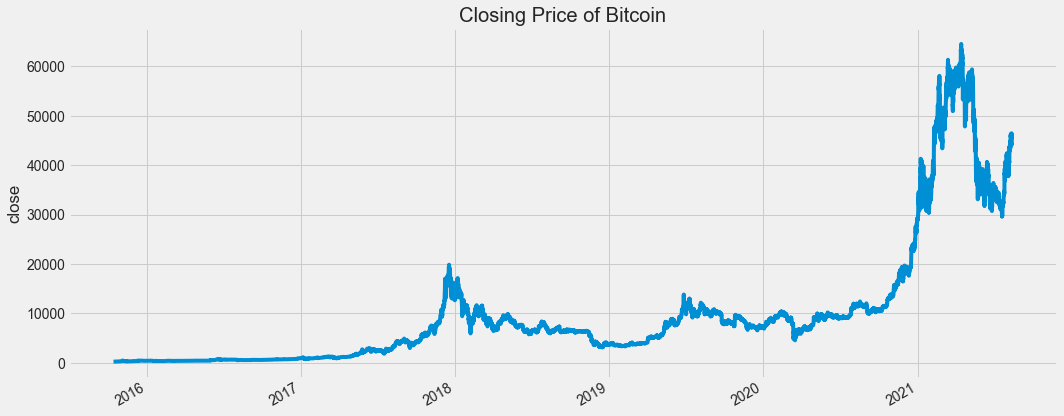

In [11]:
# Let's see a historical view of the closing price

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

data['close'].plot()
plt.ylabel('close')
plt.xlabel(None)
plt.title(f"Closing Price of Bitcoin")
    
plt.tight_layout()

### Volumes traded

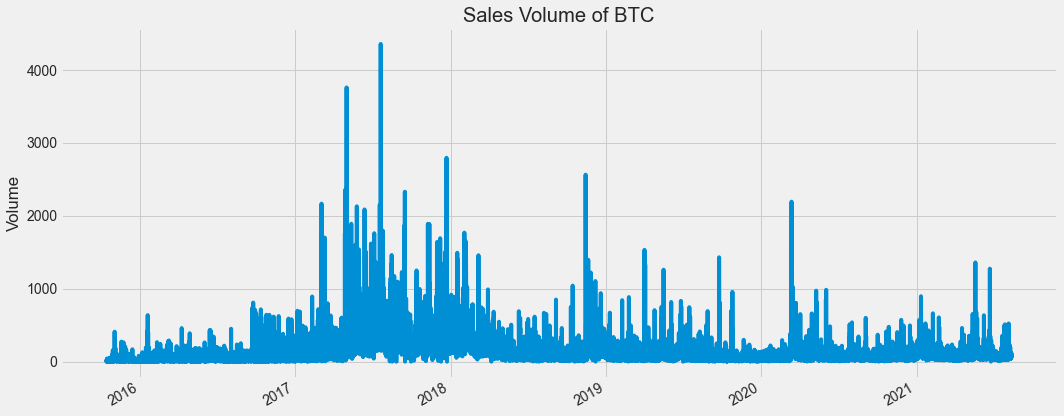

In [12]:
# Let's see a historical view of the closing price

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

data['volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title(f"Sales Volume of BTC")
    
plt.tight_layout()

In [13]:
data.tail(20)

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,dist_ema12,ema26,dist_ema26,ema21,dist_ema21,ema50,dist_ema50,ema34,dist_ema34,ema55,dist_ema55,ema99,dist_ema99,ema200,dist_ema200,rsi,K,D,sma,bollinger_up,bollinger_down,dist_bollinger_up,dist_bollinger_down,vol_roc,4h Return,4h Gradient,boll_width,high_low_avg,stoch_rsi,perc_bb
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-08-09 16:00:00,45910.91,46500.00,45727.30,45993.04,137.089807,10.734458,10.747208,10.730451,10.736245,44571.496469,1421.543531,43371.937718,2621.102282,43759.338359,2233.701641,41982.854165,4010.185835,42843.101178,3149.938822,41743.942419,4249.097581,40006.446742,5986.593258,37987.217196,8005.822804,70.148150,94.771586,67.045807,44070.2500,46130.448656,42010.051344,-137.408656,3982.988656,-0.305097,0.178890,82.13,4120.397313,46113.650,80.908697,0.966652
2021-08-09 20:00:00,45993.04,46449.06,44870.00,46279.23,158.590229,10.736245,10.746112,10.711525,10.742449,44834.224705,1445.005295,43587.292702,2691.937298,43988.419417,2290.810583,42151.339492,4127.890508,43039.451396,3239.778604,41905.916975,4373.313025,40131.902407,6147.327593,38069.724786,8209.505214,71.374109,95.526394,86.268487,44273.8005,46363.613823,42183.987177,-84.383823,4095.242823,0.156835,0.622246,286.19,4179.626646,45659.530,90.897441,0.979811
2021-08-10 00:00:00,46279.23,46729.86,45665.85,45727.39,46.187369,10.742449,10.752139,10.729106,10.730453,44971.634750,755.755250,43745.818428,1981.571572,44146.507652,1580.882348,42291.576766,3435.813234,43193.047888,2534.342112,42042.398155,3684.991845,40243.812159,5483.577841,38145.920460,7581.469540,65.765606,84.232420,91.510133,44413.3700,46499.837074,42326.902926,-772.447074,3400.487074,-0.708763,-1.192414,-551.84,4172.934148,46197.855,87.871277,0.814891
2021-08-10 04:00:00,45727.39,46031.73,45334.77,45999.32,39.576304,10.730453,10.737086,10.721830,10.736382,45129.740173,869.579827,43912.744470,2086.575530,44314.945138,1684.374862,42436.978462,3562.341538,43353.406294,2645.913706,42183.716792,3815.603208,40358.922316,5640.397684,38224.063739,7775.256261,67.136030,75.459170,85.072661,44572.8960,46630.488342,42515.303658,-631.168342,3484.016342,-0.143136,0.594676,271.93,4115.184684,45683.250,80.265916,0.846625
2021-08-10 08:00:00,45999.32,46183.47,45219.00,45380.64,52.556038,10.736382,10.740377,10.719273,10.722841,45168.340147,212.299853,44021.477473,1359.162527,44411.826489,968.813511,42552.416169,2828.223831,43469.248220,1911.391780,42297.892621,3082.747379,40459.356670,4921.283330,38295.273453,7085.366547,61.139402,49.951010,69.880866,44655.9280,46702.601408,42609.254592,-1321.961408,2771.385408,0.327967,-1.344976,-618.68,4093.346816,45701.235,59.915938,0.677046
2021-08-10 12:00:00,45380.64,46121.45,44899.99,45174.80,107.057966,10.722841,10.739033,10.712193,10.718295,45169.333970,5.466030,44106.908771,1067.891229,44481.187717,693.612283,42655.254751,2519.545249,43566.708322,1608.091678,42400.639313,2774.160687,40553.665536,4621.134464,38363.726453,6811.073547,59.243396,33.695577,53.035252,44752.1330,46699.146722,42805.119278,-1524.346722,2369.680722,1.037025,-0.453585,-205.84,3894.027445,45510.720,43.365415,0.608542
2021-08-10 16:00:00,45174.80,45590.79,44642.21,45517.17,127.821454,10.718295,10.727461,10.706435,10.725845,45222.847206,294.322794,44211.372566,1305.797434,44575.367925,941.802075,42767.486721,2749.683279,43678.163275,1839.006725,42511.943980,3005.226020,40652.935626,4864.234374,38434.904996,7082.265004,61.388207,19.370167,34.338918,44835.3880,46762.651502,42908.124498,-1245.481502,2609.045502,0.193946,0.757878,342.37,3854.527003,45116.500,26.854542,0.676878
2021-08-10 20:00:00,45517.17,45935.10,45250.00,45596.74,69.026396,10.725845,10.734985,10.719958,10.727592,45280.369174,316.370826,44313.992376,1282.747624,44668.219932,928.520068,42878.437830,2718.302170,43787.796231,1808.943769,42622.115267,2974.624733,40751.811713,4844.928287,38506.167036,7090.572964,61.890164,21.241307,24.769017,44944.5275,46777.792011,

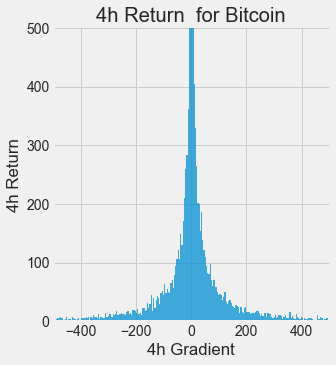

In [14]:
sns.displot(data = data, x= '4h Gradient')
plt.ylabel('4h Return')
plt.xlim([-500,500])
plt.ylim([0,500])
plt.title(f"4h Return  for Bitcoin");

In [15]:
data.columns

Index(['open', 'high', 'low', 'close', 'volume', 'log_open', 'log_high',
       'log_low', 'log_close', 'ema12', 'dist_ema12', 'ema26', 'dist_ema26',
       'ema21', 'dist_ema21', 'ema50', 'dist_ema50', 'ema34', 'dist_ema34',
       'ema55', 'dist_ema55', 'ema99', 'dist_ema99', 'ema200', 'dist_ema200',
       'rsi', 'K', 'D', 'sma', 'bollinger_up', 'bollinger_down',
       'dist_bollinger_up', 'dist_bollinger_down', 'vol_roc', '4h Return',
       '4h Gradient', 'boll_width', 'high_low_avg', 'stoch_rsi', 'perc_bb'],
      dtype='object')

In [16]:
selected_features = ['close','high','bollinger_up','rsi']
#selected_features= ['close','rsi','ema34','bollinger_up','4h Return']
#selected_features=['close','rsi','ema20','ema50','bollinger_up','4h Return']
selected_data = data[selected_features]
selected_data.tail(10)

,close,high,bollinger_up,rsi
date,,,,
2021-08-11 08:00:00,45965.21,46595.78,47074.432108,62.382400
2021-08-11 12:00:00,46475.00,46775.00,47232.646699,65.546183
2021-08-11 16:00:00,46472.94,46608.31,47366.476197,65.522202
2021-08-11 20:00:00,45550.01,46694.94,47338.887690,55.691349
2021-08-12 00:00:00,45948.06,46220.75,47274.818747,58.577957
2021-08-12 04:00:00,45289.65,46023.08,47153.082172,52.486887
2021-08-12 08:00:00,44758.93,45663.34,46930.350348,48.141461
2021-08-12 12:00:00,44204.11,44956.97,46844.888738,44.036875
2021-08-12 16:00:00,44407.09,44528.82,46896.078488,45.855691


##  BTC Stock Price

### Temporal Train-Test Split

In [17]:
train_percentage = 95

In [18]:
train_len = int(len(selected_data) * train_percentage/100)
train_len

12136

In [19]:
data_train = selected_data[:train_len]
data_test = selected_data[train_len:]


In [ ]:
train

In [20]:
print(data_train.head(1))
print(data_train.tail(1))

                      close    high  bollinger_up        rsi
date                                                        
2015-10-13 20:00:00  250.42  250.42    251.988559  62.138793
                        close      high  bollinger_up        rsi
date                                                            
2021-04-28 08:00:00  54911.46  55115.52  57424.617477  59.718319


In [21]:
print(data_test.head(5))
print(data_test.tail(5))

                        close      high  bollinger_up        rsi
date                                                            
2021-04-28 12:00:00  54370.84  55356.74  57391.335684  55.811117
2021-04-28 16:00:00  55470.60  55500.00  57394.176883  61.350848
2021-04-28 20:00:00  54886.56  56474.72  57325.819623  57.246414
2021-04-29 00:00:00  54312.41  55217.65  56885.587513  53.459992
2021-04-29 04:00:00  54492.17  54531.46  55921.410266  54.475260
                        close      high  bollinger_up        rsi
date                                                            
2021-08-12 04:00:00  45289.65  46023.08  47153.082172  52.486887
2021-08-12 08:00:00  44758.93  45663.34  46930.350348  48.141461
2021-08-12 12:00:00  44204.11  44956.97  46844.888738  44.036875
2021-08-12 16:00:00  44407.09  44528.82  46896.078488  45.855691
2021-08-12 20:00:00  44430.99  44578.23  46921.831848  46.077911


## LSTM

In [22]:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler(feature_range = (0,1))

minmax_scaler.fit(data_train)

data_train_scaled = minmax_scaler.transform(data_train)
data_test_scaled = minmax_scaler.transform(data_test)

In [23]:
minmax_scaler.data_max_

array([64567.25      , 64900.        , 66272.64103673,    94.1024183 ])

In [24]:
minmax_scaler.data_min_

array([250.42      , 250.42      , 251.98855888,   6.00372889])

In [25]:
min1 = minmax_scaler.data_min_[0]
min1

250.42

In [26]:
range1 = minmax_scaler.data_range_[0]
range1

64316.83

### Creating subsequences...

In [27]:
window_size = 18 # test with small window size
horizon = 1 #number of predictions into the future :) 
data_train_subsequences = []
fake_y_train = []
for k in range(len(data_train_scaled)-(window_size-1)-horizon):
    data_train_subsequences.append(data_train_scaled[k:k+window_size])
    fake_y_train.append(data_train_scaled[k+window_size])

In [28]:
X_train = np.array(data_train_subsequences)
y_train = np.array(fake_y_train)[:,0].reshape(-1,1)

In [29]:
X_train.shape

(12118, 18, 4)

In [30]:
y_train.shape

(12118, 1)

In [31]:
#with the same window_size & horizon as the train data
window_size = 18
horizon = 1
data_test_subsequences = []
fake_y_test = []
for k in range(len(data_test_scaled)-(window_size-1)-horizon):
    data_test_subsequences.append(data_test_scaled[k:k+window_size])
    fake_y_test.append(data_test_scaled[k+window_size])

In [32]:
X_test = np.array(data_test_subsequences)
y_test = np.array(fake_y_test)[:,0].reshape(-1,1)

In [105]:
X_test.shape

(621, 18, 4)

### Baseline

In [33]:
# baseline predictions

X_test_last_seen_value = [_[-1][0] for _ in X_test]

In [34]:
X_test_last_seen_value_uns = np.array(X_test_last_seen_value) * range1 + min1

In [35]:
X_test_last_seen_value_uns = X_test_last_seen_value_uns.reshape(-1,1)

In [36]:
y_test_unscaled = y_test * range1 + min1

In [37]:
np.mean(np.abs(y_test_unscaled - X_test_last_seen_value_uns))

577.1352979066024

### Baseline mape

In [38]:
baseline_mape = np.mean(np.abs((y_test_unscaled - X_test_last_seen_value_uns) / y_test_unscaled)) *100

In [39]:
baseline_mape 

1.4716527822480265

### LSTM

#### RNN Architecture

In [40]:
from tensorflow.keras import Sequential, layers

# Build the LSTM model
model = Sequential()

model.add(layers.LSTM(units=128,
                     return_sequences = True,
                     activation = "tanh"))
                    #activation = "relu"
                    #input_shape = X_train[0].shape))
model.add(layers.Dropout(rate=0.2)) 

model.add(layers.LSTM(units=256,
                      return_sequences = False,
                      activation = "relu"))

# model.add(layers.Dense(25,
#                          activation="relu"))
model.add(layers.Dense(32,activation = "tanh"))

#model.add(layers.Dense(16,activation="relu"))

#model.add(layers.Dense(8,activation = "relu"))

model.add(layers.Dense(1,activation = "relu"))

#model.summary()





2021-09-02 14:24:30.714705: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [41]:
model.compile(loss="mse",
             optimizer = "adam",#rmsprop
             metrics = "mae"#[my_mae]
             )

#### Training

In [42]:
from tensorflow.keras.callbacks import EarlyStopping 

es = EarlyStopping(patience = 5, restore_best_weights=True, monitor = "mae")
#monitor = "val_mean_absolute_error"

history = model.fit(X_train, y_train,
                    validation_split = 0.2,
                    batch_size=16,
                    epochs=30,
                    verbose = 1,
                    callbacks = [es])

2021-09-02 14:24:30.791576: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
606/606 [==============================] - 17s 24ms/step - loss: 8.3034e-05 - mae: 0.0054 - val_loss: 0.0072 - val_mae: 0.0496
Epoch 2/30
606/606 [==============================] - 17s 28ms/step - loss: 2.7730e-05 - mae: 0.0037 - val_loss: 0.0124 - val_mae: 0.0644
Epoch 3/30
606/606 [==============================] - 26s 42ms/step - loss: 2.7811e-05 - mae: 0.0038 - val_loss: 0.0023 - val_mae: 0.0258
Epoch 4/30
606/606 [==============================] - 22s 37ms/step - loss: 2.0610e-05 - mae: 0.0032 - val_loss: 0.0051 - val_mae: 0.0395
Epoch 5/30
606/606 [==============================] - 26s 43ms/step - loss: 2.5424e-05 - mae: 0.0035 - val_loss: 0.0047 - val_mae: 0.0389
Epoch 6/30
606/606 [==============================] - 21s 34ms/step - loss: 1.6285e-05 - mae: 0.0028 - val_loss: 9.4825e-04 - val_mae: 0.0171
Epoch 7/30
606/606 [==============================] - 22s 37ms/step - loss: 1.9098e-05 - mae: 0.0031 - val_loss: 0.0011 - val_mae: 0.0188
Epoch 8/30
606/606 [==========

In [43]:
def plot_loss_mae(history):
    
    fig, ax =plt.subplots(1,2,figsize=(20,5))
    
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
#     # --- MAE

    #ax[1].plot(history.history['mean_absolute_error'])
    #ax[1].plot(history.history['val_mean_absolute_error'])
    #ax[1].set_title('Model MAE', fontsize = 18)
    #ax[1].set_xlabel('Epoch', fontsize = 14)
    #ax[1].set_ylabel('Recall', fontsize = 14)
    #ax[1].legend(['Train', 'Val'], loc='lower right') 
    #ax[1].grid(axis="x",linewidth=0.5)
    #ax[1].grid(axis="y",linewidth=0.5)   
    
    #plt.show()
    

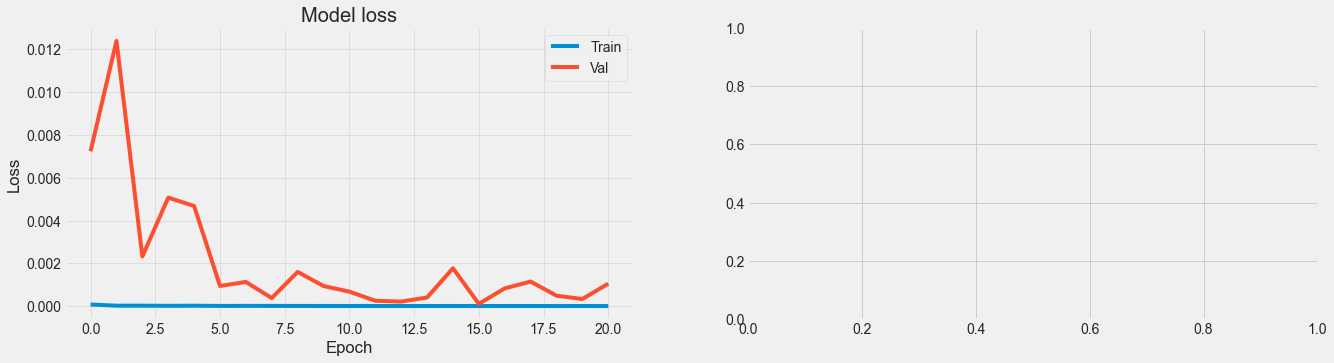

In [44]:
plot_loss_mae(history)

#### Evaluating

In [45]:
# res = model.evaluate(X_test, y_test, verbose = 1)
# res


#### Predictions

In [46]:
predictions = model.predict(X_test)


In [47]:
len(predictions), len(y_test)

(621, 621)

In [48]:
predictions[0:3]

array([[0.89349765],
       [0.88576597],
       [0.88879704]], dtype=float32)

In [49]:
y_test_unscaled = y_test * range1 + min1

In [50]:
predictions_unscaled = predictions * range1 + min1

In [51]:
print(pd.DataFrame(y_test_unscaled).tail(5))
print(pd.DataFrame(predictions_unscaled).tail(5))

            0
616  45289.65
617  44758.93
618  44204.11
619  44407.09
620  44430.99
                0
616  45847.011719
617  45309.761719
618  44671.066406
619  43983.058594
620  43895.718750


The operation computed during a `MinMaxScaler` Operation is:

$$x_{scaled} = \frac{x - x_{min}}{x_{max}- x_{min}}$$

To descale it:

$$x = x_{scaled} * (x_{max}- x_{min}) + x_{min}$$

Or use the `inverse_transform` directly provided...

In [52]:
np.mean(np.abs(y_test_unscaled - predictions_unscaled))

669.9715294132449

In [53]:
np.mean(np.abs((y_test_unscaled - predictions_unscaled) / y_test_unscaled)) *100

1.7083680225514344

In [54]:
y_test_unscaled.shape

(621, 1)

In [55]:
predictions_unscaled.shape

(621, 1)

In [101]:
from tensorflow.keras.models import load_model, save_model

In [103]:
save_model(model, "new_data_high_bollinger_up_rsi_1_71_upgrade_trace",save_traces=False)

INFO:tensorflow:Assets written to: new_data_high_bollinger_up_rsi_1_71_upgrade_trace/assets


INFO:tensorflow:Assets written to: new_data_high_bollinger_up_rsi_1_71_upgrade_trace/assets


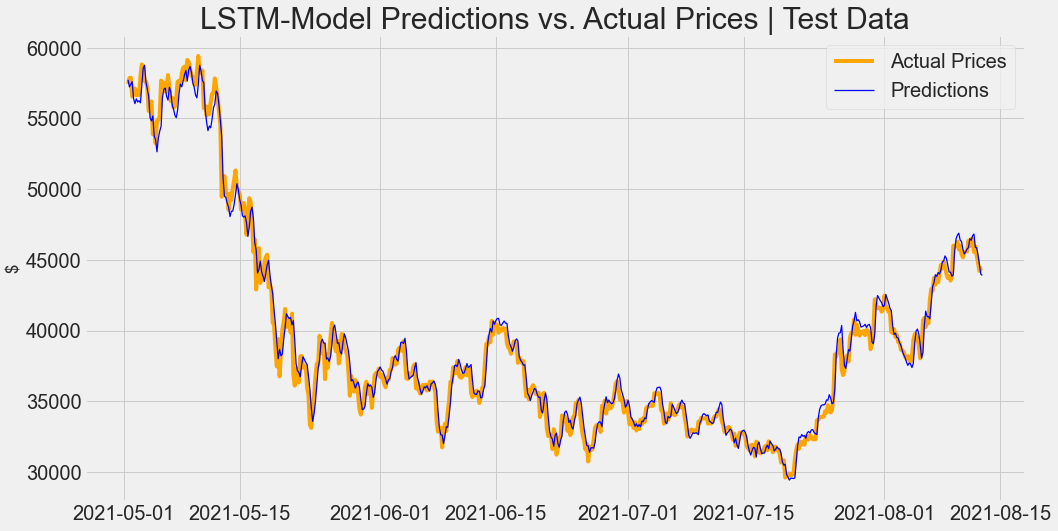

In [100]:
dates =data_test[window_size:window_size+len(y_test_unscaled)]

fig = plt.figure(figsize=(15, 8))

plt.plot(dates.index,y_test_unscaled, label = "Actual Prices",color="orange")
plt.plot(dates.index,predictions_unscaled, label = "Predictions",linewidth=1.25,color="blue")
plt.title("LSTM-Model Predictions vs. Actual Prices | Test Data",fontdict = {'fontsize' : 30})
plt.ylabel("$")
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(prop={'size':20})
plt.show()

In [58]:
stop stop 

SyntaxError: invalid syntax (958000207.py, line 1)

In [ ]:
#import joblib
# from tensorflow.keras.models import load_model, save_model
# save_model(model, "rsi_boll_up_down_4h_return")

### Test Model on Coingecko

### Test based on 1 window_size and 1 prediction (4 hours in de future) with Coingecko Data

In [ ]:
# X_gecko = coingecko.dropna()[-18:]

In [ ]:
# X_gecko.shape

In [ ]:
# x_gecko_scaled = minmax_scaler.transform(X_gecko)

In [ ]:
# x_gecko_scaled_reshaped = x_gecko_scaled.reshape(1,18,4) #18 is the window size, 9 is number of features. 

In [ ]:
# predictions_api = model.predict(x_gecko_scaled_reshaped)

In [ ]:
# predictions_api

In [ ]:
# predictions_api_unscaled = predictions_api * range1 + min1 

In [ ]:
# predictions_api_unscaled


### Creating X_test_gecko and y_test_gecko

In [77]:
coingecko = get_coingecko()

In [78]:
coingecko = feature_engineer(coingecko)

In [79]:
X_test_gecko = coingecko.dropna()[-144:]

In [ ]:
# print(X_test_gecko.head(1))
# print(X_test_gecko.tail(1))

In [ ]:
#selected_features = ['close','high','bollinger_up','rsi']

In [80]:
X_test_gecko = X_test_gecko[selected_features]

In [81]:
X_test_gecko.tail(3)

,close,high,bollinger_up,rsi
2021-09-02 04:00:00,49638.76,49734.07,49374.882485,64.069714
2021-09-02 08:00:00,49847.11,49847.11,49574.652945,65.349958
2021-09-02 12:00:00,50050.14,50056.55,49890.630233,66.598904


In [82]:
X_test_gecko_scaled = minmax_scaler.transform(X_test_gecko)

In [83]:
X_test_gecko.shape

(144, 4)

In [84]:
#with the same window_size & horizon as the train data
window_size = 18
horizon = 1
X_test_gecko_sub = []
fake_y_test_gecko_sub = []
for k in range(len(X_test_gecko_scaled)-(window_size-1)-horizon):
    X_test_gecko_sub.append(X_test_gecko_scaled[k:k+window_size])
    fake_y_test_gecko_sub.append(X_test_gecko_scaled[k+window_size])

In [85]:
X_test_gecko_np = np.array(X_test_gecko_sub)
y_test_gecko_np = np.array(fake_y_test_gecko_sub)[:,0].reshape(-1,1)

In [86]:
print(X_test_gecko_np.shape)
print(y_test_gecko_np.shape)

(126, 18, 4)
(126, 1)


In [87]:
predictions_gecko = model.predict(X_test_gecko_np)

In [88]:
predictions_gecko_unscaled = predictions_gecko * range1 + min1

In [89]:
predictions_gecko_unscaled

array([[45101.746],
       [44026.95 ],
       [43899.254],
       [43560.355],
       [44723.15 ],
       [45598.625],
       [46238.934],
       [46550.36 ],
       [46603.555],
       [47436.96 ],
       [47814.61 ],
       [47841.438],
       [46564.414],
       [46517.03 ],
       [46555.043],
       [46766.49 ],
       [47143.176],
       [46548.043],
       [45704.93 ],
       [45429.95 ],
       [45726.586],
       [46801.137],
       [47807.297],
       [47588.297],
       [47305.53 ],
       [46206.402],
       [45935.7  ],
       [45750.42 ],
       [45891.   ],
       [45511.35 ],
       [46222.29 ],
       [45971.016],
       [45434.367],
       [44567.438],
       [44203.34 ],
       [44646.562],
       [44839.113],
       [44799.625],
       [44995.613],
       [44368.68 ],
       [44017.082],
       [43663.664],
       [43604.63 ],
       [44691.91 ],
       [46352.598],
       [46798.86 ],
       [47259.797],
       [47183.598],
       [47154.832],
       [48332.953],


In [90]:
y_test_gecko_unscaled = y_test_gecko_np * range1 + min1

In [91]:
np.mean(np.abs(y_test_gecko_unscaled - predictions_gecko_unscaled))

604.1490066964298

In [94]:
np.mean(np.abs((y_test_gecko_unscaled - predictions_gecko_unscaled) / y_test_gecko_unscaled)) *100

1.2742481082756534

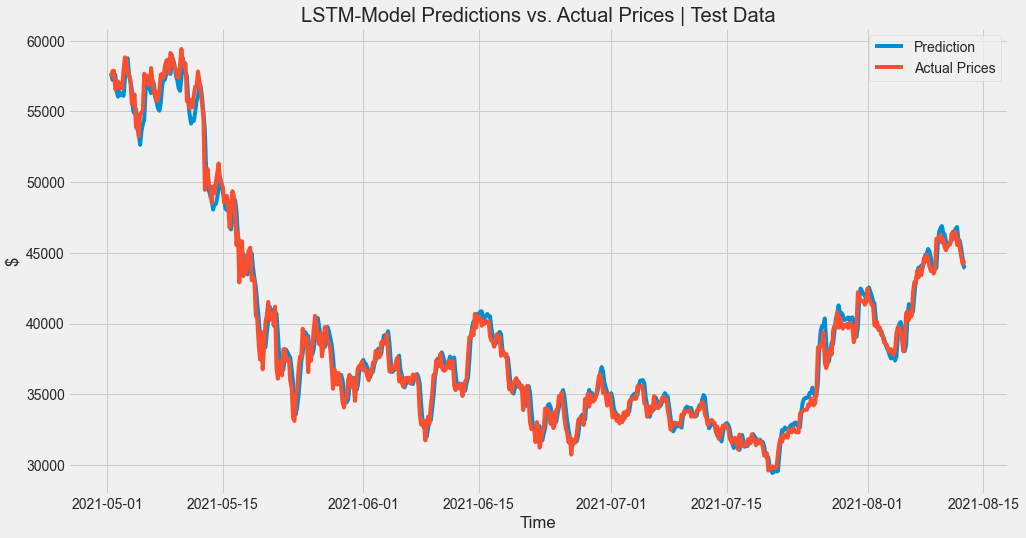

In [92]:
dates =data_test[window_size:window_size+len(y_test_unscaled)]

fig = plt.figure(figsize=(15, 8))

plt.plot(dates.index,predictions_unscaled, label = "Prediction")
plt.plot(dates.index,y_test_unscaled, label = "Actual Prices")
plt.title("LSTM-Model Predictions vs. Actual Prices | Test Data")
plt.ylabel("$")
plt.xlabel("Time")
plt.legend()
plt.show()

In [ ]:
dates =data_test[window_size:window_size+len(y_test_unscaled)]

fig = plt.figure(figsize=(15, 8))

plt.plot(predictions_gecko_unscaled, label = "Prediction", color="orange")
plt.plot(y_test_gecko_unscaled, label = "Actual Prices",color="blue")
plt.title("LSTM-Model Predictions vs. Actual Prices | Coingecko API Data")
plt.ylabel("$")
#plt.xlabel("Time")
plt.legend()
plt.show()


